In [1]:
exec(open("inc_notebook.py").read())

In [2]:
import logging, sys, math,os
exec(open("estimator/initKeras.py").read())

Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

if sys.modules.get( 'library.LivePlotKeras', False ) != False :
    del sys.modules['library.LivePlotKeras'] 
if sys.modules.get( 'LivePlotKeras', False ) != False :
    del sys.modules['LivePlotKeras'] 
from library.LivePlotKeras import *

logging.warning( "LivePlotKeras loaded" )

livePlotKeras = LivePlotKeras()

In [4]:
if sys.modules.get( 'estimator.EstimatorIO', False ) != False :
    del sys.modules['estimator.EstimatorIO'] 
if sys.modules.get( 'EstimatorIO', False ) != False :
    del sys.modules['EstimatorIO'] 
from estimator.EstimatorIO import *

logging.warning( "EstimatorIO loaded" )

estimatorIO = EstimatorIO()

In [5]:
from embedding.MultipleBinEmbeddingType import *

if sys.modules.get( 'library.MultipleBinDataGenerator', False ) != False :
    del sys.modules['library.MultipleBinDataGenerator'] 
if sys.modules.get( 'MultipleBinDataGenerator', False ) != False :
    del sys.modules['MultipleBinDataGenerator'] 
from library.MultipleBinDataGenerator import *

logging.warning( "MultipleBinDataGenerator loaded" )

trainGenerator = MultipleBinDataGenerator(embedding=MultipleBinEmbeddingType.CNN_STATS, 
                                          batch_size=32, windowSize = 36, stride = 6)

D:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [14]:

model_input = layers.Input( shape = ( 36, 275, 1 ) )
x = layers.Conv2D(64, 
        kernel_size = (20,1), 
        padding = 'same'
        )(model_input)

x = layers.LeakyReLU(alpha=0.1)(x)

# x = layers.Conv2D(32, kernel_size=(10,1), padding='same')(x)
# x = layers.LeakyReLU(alpha=0.1)(x)
# # x = layers.Dropout(0.2)(x)

x = layers.Conv2D(32, kernel_size=(10,1), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(16, kernel_size=(3,1), activation=activations.relu, padding='same')(x)
# x = layers.Flatten()(x)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(1)(x)

model = models.Model(model_input, x, name = "1DCNN-ColumnKernel4-Global-Average")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 36, 275, 1)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 36, 275, 64)       1344      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 36, 275, 64)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 36, 275, 32)       20512     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 36, 275, 32)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 36, 275, 32)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 36, 275, 16)       1552      
__________

In [15]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
             loss = losses.MSE,
             metrics = [metrics.MSE, metrics.MAE])

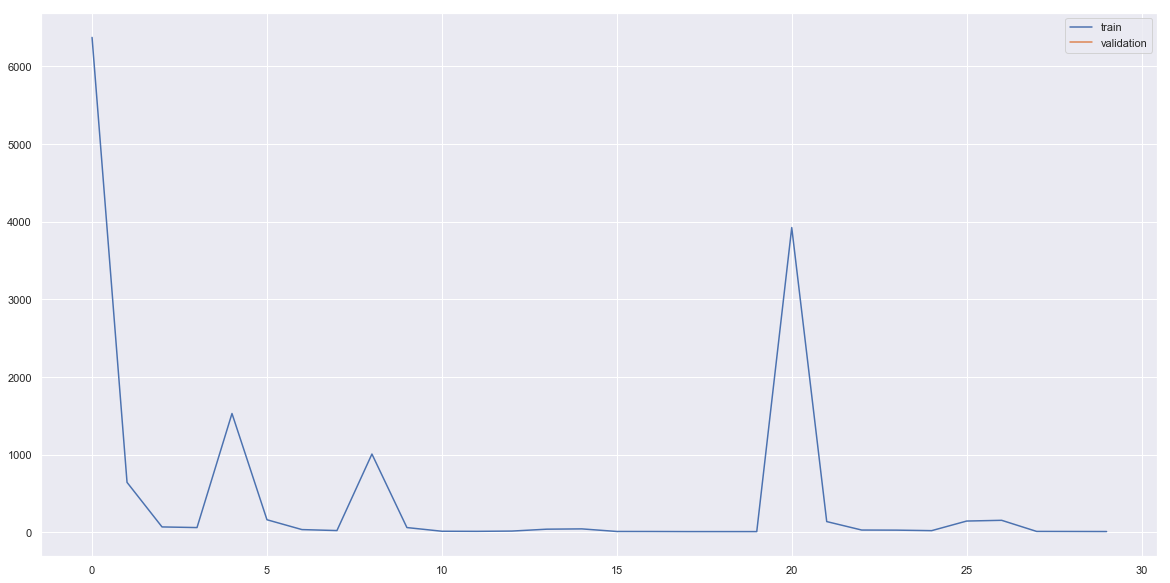

In [16]:
history = model.fit_generator( generator=trainGenerator,
                    use_multiprocessing=False, 
                    workers=3, 
                    initial_epoch = 0,
                    epochs=30,
                    max_q_size = 100,
                    steps_per_epoch = trainGenerator.getNumberOfBatches(),
                    callbacks = [livePlotKeras]
                   )

In [ ]:
estimatorIO.save(model, model.name)

In [ ]:
if sys.modules.get( 'library.EmbeddingStatsGeneratorForTestPos', False ) != False :
    del sys.modules['library.EmbeddingStatsGeneratorForTestPos'] 
if sys.modules.get( 'EmbeddingStatsGeneratorForTestPos', False ) != False :
    del sys.modules['EmbeddingStatsGeneratorForTestPos'] 
from library.EmbeddingStatsGeneratorForTestPos import *  
logging.warning( "EmbeddingStatsGeneratorForTestPos loaded" )

embeddingType = 'cnn-stats-test'
generator = EmbeddingStatsGeneratorForTestPos(embeddingType = embeddingType)

In [ ]:
import pandas as pd
output = pd.read_csv('F:/myProjects/cmps242/earthquake/data/sample_submission.csv')
dic = {}
for testName, batch in generator.batchesByFile():
    print(f'test: {testName}')
#     print(trainModel.predict(batch, batch_size=generator.numberOfEmbeddingPerFile))
    pred = model.predict(batch, batch_size=generator.numberOfEmbeddingPerFile)
    dic[testName] = pred
#     print( output.index[output['seg_id'] == testName])
    output.at[output.index[output['seg_id'] == testName], 'time_to_failure'] = np.median(pred)

In [ ]:
output.to_csv(f'F:/myProjects/cmps242/earthquake/data/{model.name}.csv', index=False)